In [1]:
%matplotlib inline
import numpy as np
from graph import Graph
import operator
import matplotlib.pyplot as plt

from   matplotlib.ticker import LinearLocator, FormatStrFormatter
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute

from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

from qiskit.aqua.components.optimizers import SPSA, SLSQP, COBYLA

In [2]:
def U_B(qc, beta):
    for q in range(qc.n_qubits):
        qc.rx(2 * beta, q)

In [3]:
def U_C(qc, gamma, G):
    for edge in G.E:
        q1 = edge[0]
        q2 = edge[1]
        qc.cx(q1, q2)
        qc.rz(gamma, q2)
        qc.cx(q1, q2)

In [4]:
def expval(H, psi):
    psi_dagger = np.conjugate(psi)
    return np.matmul(np.matmul(psi, H), psi_dagger)

In [5]:
def QAOA(G, gammas, betas, edge=None, qc=None, p=1):
    n = G.n
    if qc is None:
        qr = QuantumRegister(n)
        cr = ClassicalRegister(n)
        qc = QuantumCircuit(qr, cr)

    assert n == qc.n_qubits, 'the circuit\'s number of qubits ({}) \
                                is not equal to |V(G)|=({})'.format(qc.n_qubits, n)
    
    for q in range(n):
        qc.h(q)
        
    for i in range(p):
        U_C(qc, gammas[i], G)
        U_B(qc, betas[i])
    
    if edge is None:
        return qc.measure(range(n), range(n))

    qc.measure(range(n), range(n))
    
    provider = IBMQ.load_account()
    backend = provider.get_backend('ibmqx2')
    shots   = 4096

    job_exp = execute(qc, backend=backend, shots=shots)
    job_monitor(job_exp)
    exp_results = job_exp.result()
    counts = exp_results.get_counts()
    
    Z = [[1, 0], [0, -1]]
    Z2 = np.kron(Z, Z)
    
    q1 = edge[0]
    q2 = edge[1]
    
    amplitudes_n = [0] * 4

    for bin_string in counts.keys():
        if ((bin_string[q1] == '0') and (bin_string[q2] == '0')):
            amplitudes_n[0] += counts[bin_string]/shots
        elif ((bin_string[q1] == '0') and (bin_string[q2] == '1')):
            amplitudes_n[1] += counts[bin_string]/shots
        elif ((bin_string[q1] == '1') and (bin_string[q2] == '0')): 
            amplitudes_n[2] += counts[bin_string]/shots
        else:
            amplitudes_n[3] += counts[bin_string]/shots
    
    return expval(Z2, amplitudes_n)

In [6]:
def maxcut(G, lower_bound=-np.pi, upper_bound=np.pi, step_size=0.1,
           maxiter=100, tol=0.0001, shots=1024, p=1, is_numerical=True, plot_most_freq_bits=True):
    print("\nNumber of layers: {:d}".format(p))
    def objective(params):
        cost = 0
        gammas = [params[0]] if p == 1 else params[:p]
        betas = [params[1]] if p == 1 else params[p:]
        for edge in G.E:
            expval = 1 - QAOA(G, gammas, betas, edge=edge, p=p)
            cost -= 0.5 * expval * (edge[2] if G.isWeighted else 1)
        return cost
    
    def plot_hist(counts, color='lightpink'):
        sorted_counts = {k: v for k, v in sorted(counts.items(), key=lambda item: item[1])}
        most_freq_bits = sorted_counts if len(sorted_counts) <= 30 else list(sorted_counts)[len(sorted_counts)-30:]
        plt.bar(most_freq_bits, [counts[bit] for bit in most_freq_bits], color=color)
        _, _ = plt.xticks(rotation=80)
        plt.show()
    
    if is_numerical: #implement non-numerical
        initial_params = 0.01 * np.random.rand(2 * p)

        optimizer = COBYLA(maxiter=maxiter, tol=tol)
        minimizers, min_cost, _ = optimizer.optimize(num_vars=2*p,
                                                     objective_function=objective,
                                                     initial_point=initial_params)
        
        
        opt_gammas = [minimizers[0]] if p == 1 else minimizers[:p]
        opt_betas = [minimizers[1]] if p == 1 else minimizers[p:]      
        
    print('Minimal expectation value: {}'.format(min_cost))
    print('Optimal parameters: \nγ = {}, \nβ = {}'.format(opt_gammas, opt_betas))
    
    # to do: real hardware
    qr = QuantumRegister(G.n)
    cr = ClassicalRegister(G.n)
    qc = QuantumCircuit(qr, cr)
    QAOA(G, opt_gammas, opt_betas, qc=qc, p=p)
    
    provider = IBMQ.load_account()
    backend = provider.get_backend('ibmqx2')
    job_exp = execute(qc, backend=backend, shots=shots)
    job_monitor(job_exp)
    exp_results = job_exp.result()
    counts = exp_results.get_counts()

    most_freq_bit = max(counts.items(), key=operator.itemgetter(1))[0]
    
    if plot_most_freq_bits:
        print('\nHistogram of the most frequent bits:')
        plot_hist(counts)
        
    print('\nMost frequently sampled bit string is: {}'.format(most_freq_bit))
    
    cut_edges = []
    for edge in G.E:
        if most_freq_bit[edge[0]] != most_freq_bit[edge[1]]:
            cut_edges.append(edge)
    g.draw(colors=['r' if bit == '0' else 'c' for bit in most_freq_bit], cut_edges=cut_edges)
    
    
    return min_cost, counts, most_freq_bit

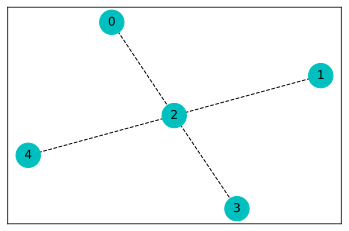

In [12]:
E = [(2, 0), (1, 2), (2, 3), (4, 2)]

g = Graph(5, E)
g.draw()

In [13]:
# TO-DOs

# 2. Drawing the circuit
# 3. assertions
# 4. extra imports?
# 5. comments?
# instead of maxiter use errors
# try spsla
# 


Number of layers: 2


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run
Minimal expectation value: -2.0507453083992004
Optimal parameters: 
γ = [1.00112684 0.00885095], 
β = [1.0090259  0.00729036]


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run

Histogram of the most frequent bits:


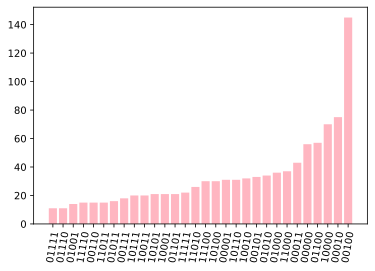


Most frequently sampled bit string is: 00100


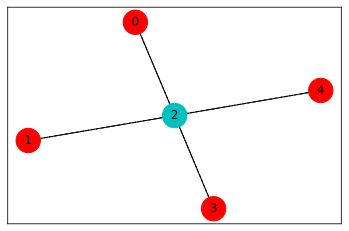

In [15]:
cost, counts, most_freq_bit = maxcut(g, maxiter=4, p=2)